In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import Counter

In [13]:
suits=['S','D','C','H']
ranks=['A','2','3','4','5','6','7','8','9','10','J','Q','K']
rank_value={'2': 2, '3': 3, '4': 4, '5': 5, '6': 6,'7': 7, '8': 8, '9': 9, '10': 10,'J': 11, 'Q': 12, 'K': 13, 'A': 14}
hand_names = { 10: "Royal Flush",9: "Straight Flush",8: "Four of a Kind",7: "Full House",6: "Flush",5: "Straight",4: "Three of a Kind",3: "Two Pair",2: "One Pair",1: "High Card" }
deck=[r+s for s in suits for r in ranks]

The 'shuffle()' function creates a shuffled deck of 52 cards.  
It keeps the original deck intact and returns a new randomly ordered deck.  
We use 'np.random.shuffle()' for randomization.

In [14]:
def shuffle():
    p=deck.copy()
    np.random.shuffle(p)
    return p

The 'dealing()' function deals cards to opponents and completes the community cards.  

- Removes user's hand and any pre-dealt community cards from the deck.  
- Deals 2 cards to each opponent.  
- Completes the community cards to a total of 5 cards.  

Inputs:
- Shuffled deck
- Number of players
- User's hand
- Optional pre-dealt community cards (flop/turn)

Outputs:
- Opponent hands
- Complete community cards

In [15]:
def dealing(s_deck,n,hand_card, community_cards=[]):
    for card in hand_card:
        s_deck.remove(card)
    for card in community_cards:
        if card in s_deck: # Check if card is still in the deck before removing
            s_deck.remove(card)
    opponents=[]
    for i in range(1,n):
        l=[s_deck.pop(),s_deck.pop()]
        opponents.append(l)
    remaining_community_cards_to_deal = 5 - len(community_cards)
    community = community_cards + [s_deck.pop() for i in range(remaining_community_cards_to_deal)]
    return opponents,community

The 'card_merging()' function combines the player's hand with the community cards.  
The resulting list of cards is used to evaluate the best poker hand.

In [16]:
def card_merging(card,community):
    return card+community

The 'evaluate()' function evaluates a list of 5-7 cards and determines the best poker hand according to Texas Hold'em rules.  

It handles:
- High Card, One Pair, Two Pair, Three of a Kind
- Straight, Flush, Full House, Four of a Kind
- Straight Flush and Royal Flush

It returns:
- Hand rank (numeric, 1-10)
- Rank values for tie-breaking
- Human-readable hand name

In [17]:
def evaluate(cards):
    values=[c[:-1] for c in cards]
    suits=[c[-1] for c in cards]
    nums=sorted([rank_value[v] for v in values],reverse=True)
    value_count=Counter(nums)
    suit_count=Counter(suits)
    sorted_counts=sorted(value_count.items(),key=lambda x: (x[1],x[0]),reverse=True)
    flush_suit=None
    for s,count in suit_count.items():
        if count>=5:
            flush_suit=s
            break
    unique_values=sorted(set(nums),reverse=True)
    is_straight,top_straight=False,None
    if len(unique_values)>=5:
        for i in range(len(unique_values)-4):
            w=unique_values[i:i+5]
            if all(w[j]-1==w[j+1] for j in range(4)):
                is_straight=True
                top_straight=w[0]
                break
        if {14,2,3,4,5}.issubset(set(nums)):
            is_straight=True
            top_straight=5
    if flush_suit:
        flush_num=sorted([rank_value[c[:-1]] for c in cards if c[-1]==flush_suit],reverse=True)
        flush_unique=sorted(set(flush_num),reverse=True)
        if len(flush_unique)>=5:
            for i in range(len(flush_unique)-4):
                w=flush_unique[i:i+5]
                if all(w[j]-1==w[j+1] for j in range(4)):
                    if w[0]==14:
                        return (10,[14],hand_names[10])
                    return (9,[w[0]],hand_names[9])
            if {14,2,3,4,5}.issubset(set(flush_unique)):
                return (9,[5],hand_names[9])
    if sorted_counts[0][1]==4:
        p=sorted_counts[0][0]
        q=max([v for v in nums if v!=p])
        return (8,[p,q],hand_names[8])
    if sorted_counts[0][1]==3 and sorted_counts[1][1]>=2:
        p=sorted_counts[0][0]
        q=sorted_counts[1][0]
        return (7,[p,q],hand_names[7])
    if flush_suit:
        return(6,flush_num[:5],hand_names[6])
    if is_straight:
        return(5,[top_straight],hand_names[5])
    if sorted_counts[0][1]==3:
        p=sorted_counts[0][0]
        q=sorted([v for v in nums if v!=p], reverse=True)[:2]
        return (4,[p]+q,hand_names[4])
    if sorted_counts[0][1]==2 and sorted_counts[1][1]==2:
        p=sorted_counts[0][0]
        q=sorted_counts[1][0]
        r=max([v for v in nums if v not in (p,q)])
        return (3,[p,q,r],hand_names[3])
    if sorted_counts[0][1]==2:
        p=sorted_counts[0][0]
        q=sorted([v for v in nums if v!=p],reverse=True)[:3]
        return (2,[p]+q,hand_names[2])
    return (1,nums[:5],hand_names[1])

The 'montecarlo()' function simulates thousands of games to estimate the probabilities of winning, tying, or losing for a given hand.  

- Randomly shuffles the deck and deals cards to opponents.  
- Evaluates the user's hand against all opponents.  
- Tracks win/tie/lose statistics and hand type distribution.  

Inputs:
- Deck of cards
- Number of players
- User hand
- Known community cards (optional)
- Number of simulations

Outputs:
- DataFrame with simulation results
- Estimated win, tie, lose probabilities
- Distribution of user's hand types

In [18]:
def montecarlo(deck, n, hand_card, pre_dealt_community_cards=[], s_count=10000):
    results=[]
    win_count=0
    tie_count=0
    for i in range(s_count):
        s_deck=shuffle()
        opponents,community=dealing(s_deck, n, hand_card, pre_dealt_community_cards)
        user_eval=evaluate(card_merging(hand_card, community))
        opp_evals=[evaluate(card_merging(o, community)) for o in opponents]
        all_evals=[user_eval]+opp_evals
        max_eval=max(all_evals)
        winners=[i for i,j in enumerate(all_evals) if j==max_eval]
        if 0 in winners:
            if len(winners)==1:
                win_count+=1
                result='Win'
            else:
                tie_count+=1
                result='Tie'
        else:
            result='Lose'
        results.append({"Simulation": i,"User Hand": user_eval[2],"Opponent Hands": [ev[2] for ev in opp_evals],"Result": result})

    df=pd.DataFrame(results)
    ev_win=win_count/s_count
    ev_tie=tie_count/s_count
    ev_lose=1-ev_win-ev_tie
    hand_count=df["User Hand"].value_counts(normalize=True)*100
    hand_distribution = hand_count.to_dict()

    return df, ev_win, ev_tie, ev_lose, hand_distribution

In [19]:
u_input = input("Enter your hand cards in the format 'Rank+suits': ")
n = int(input('Enter number of players: '))
hand_card = u_input.split()

if len(hand_card) != 2:
    raise ValueError("You must enter exactly 2 cards for Texas Hold'em.")

community_cards = []

flop_input = input("Enter the flop cards (3 cards) in the format 'Rank+suits Rank+suits Rank+suits': ")
flop_cards = flop_input.split()

if len(flop_cards) != 3:
    raise ValueError("You must enter exactly 3 cards for the flop.")

all_used_cards = set(hand_card)
for card in flop_cards:
    if card not in deck:
        raise ValueError(f"Invalid card entered: {card}")
    if card in all_used_cards:
        raise ValueError(f"Card already in hand or community cards: {card}")
    community_cards.append(card)
    all_used_cards.add(card)

print("\n--- After Flop ---")
print(f"Community cards: {community_cards}")
df, ev_win, ev_tie, ev_lose, hand_distribution = montecarlo(deck, n, hand_card, community_cards, s_count=10000)
n_sim = len(df)
print(f"Win Probability: {ev_win*100:.2f}%")
print(f"Tie Probability: {ev_tie*100:.2f}%")
print(f"Lose Probability: {ev_lose*100:.2f}%\n")
ci = 1.96 * math.sqrt(ev_win * (1 - ev_win) / n_sim)
print(f"Win probability 95% CI: {ev_win*100:.2f}% ± {ci*100:.2f}%")
ci_tie = 1.96 * math.sqrt(ev_tie * (1 - ev_tie) / n_sim)
print(f"Tie probability 95% CI: {ci_tie*100:.2f}%")
print("User Hand Distribution (percentage over all simulations):")
for i, j in hand_distribution.items():
    print(f"{i}: {j:.2f}%")

Enter your hand cards in the format 'Rank+suits': 5H 7D
Enter number of players: 2
Enter the flop cards (3 cards) in the format 'Rank+suits Rank+suits Rank+suits': KS 7C 9H

--- After Flop ---
Community cards: ['KS', '7C', '9H']
Win Probability: 58.14%
Tie Probability: 4.08%
Lose Probability: 37.78%

Win probability 95% CI: 58.14% ± 0.97%
Tie probability 95% CI: 0.39%
User Hand Distribution (percentage over all simulations):
One Pair: 50.99%
Two Pair: 37.68%
Three of a Kind: 7.14%
Full House: 2.67%
Straight: 1.43%
Four of a Kind: 0.09%


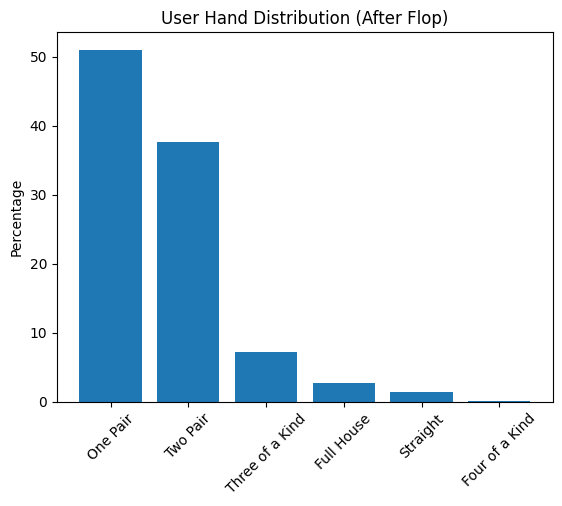

In [20]:
plt.bar(hand_distribution.keys(),hand_distribution.values())
plt.xticks(rotation=45)
plt.ylabel("Percentage")
plt.title("User Hand Distribution (After Flop)")
plt.show()

In [21]:
turn_input = input("\nEnter the turn card (1 card) in the format 'Rank+suits': ")
turn_card = turn_input.split()

if len(turn_card) != 1:
    raise ValueError("You must enter exactly 1 card for the turn.")

turn_card = turn_card[0]
all_used_cards = set(hand_card + community_cards)
if turn_card not in deck:
    raise ValueError(f"Invalid card entered: {turn_card}")
if turn_card in all_used_cards:
    raise ValueError(f"Card already in hand or community cards: {turn_card}")

community_cards.append(turn_card)

print("\n--- After Turn ---")
print(f"Community cards: {community_cards}")
df, ev_win, ev_tie, ev_lose, hand_distribution = montecarlo(deck, n, hand_card, community_cards, s_count=10000)
n_sim = len(df)
print(f"Win Probability: {ev_win*100:.2f}%")
print(f"Tie Probability: {ev_tie*100:.2f}%")
print(f"Lose Probability: {ev_lose*100:.2f}%\n")
ci = 1.96 * math.sqrt(ev_win * (1 - ev_win) / n_sim)
print(f"Win probability 95% CI: {ev_win*100:.2f}% ± {ci*100:.2f}%")
ci_tie = 1.96 * math.sqrt(ev_tie * (1 - ev_tie) / n_sim)
print(f"Tie probability 95% CI: {ci_tie*100:.2f}%")
print("User Hand Distribution (percentage over all simulations):")
for i, j in hand_distribution.items():
    print(f"{i}: {j:.2f}%")



Enter the turn card (1 card) in the format 'Rank+suits': KH

--- After Turn ---
Community cards: ['KS', '7C', '9H', 'KH']
Win Probability: 57.50%
Tie Probability: 5.88%
Lose Probability: 36.62%

Win probability 95% CI: 57.50% ± 0.97%
Tie probability 95% CI: 0.46%
User Hand Distribution (percentage over all simulations):
Two Pair: 91.40%
Full House: 8.60%


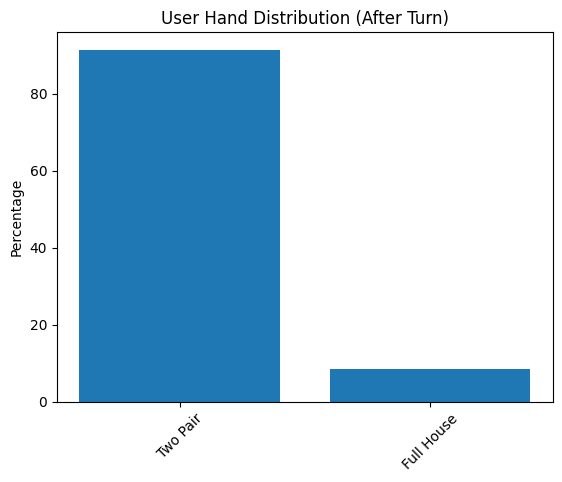

In [22]:
plt.bar(hand_distribution.keys(),hand_distribution.values())
plt.xticks(rotation=45)
plt.ylabel("Percentage")
plt.title("User Hand Distribution (After Turn)")
plt.show()